# Ramachandran plot (gerdos/PyRAMA engine)

In this minitool I want to share with you the implemetation of Gerdos pyRAMA tool for ploting Ramachandran plots of proteins inside of jupyter notebook. The full code of pyRAMA can be found on gerdos Github page (https://github.com/gerdos/PyRAMA).

The aim of this minitool is not just to visualize the Ramachandran plots but also perform some structural visualization using nglview. Let's put the hands on it.

For Ramachandran plots we need the pyRAMA code. Next cell contains such code ready to work directly on jupyter as funtion, but before to run the funtion we need 2 things and they are mandatory.

1- The pdb file we want to analyze (from the PDB database or a model that we made).
2- The rama500- .data files which store the density profiles or occupancies as a grid (download from my github at: )

Now let's run the script

In [1]:
pdb_file='1eve.pdb' #This is the pdb we will analize

In [2]:
import math
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
from Bio import PDB
from matplotlib import colors

def plot_ramachandran(file):
    __file__=file

    """
    The preferences were calculated from the following artice:
    Lovell et al. Structure validation by Calpha geometry: phi,psi and Cbeta deviation. 2003
    DOI: 10.1002/prot.10286
    """

    # General variable for the background preferences
    rama_preferences = {
        "General": {
            "file": "rama500-general.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
            "bounds": [0, 0.0005, 0.02, 1],
        },
        "GLY": {
            "file": "rama500-gly-sym.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#FFE8C5', '#FFCC7F']),
            "bounds": [0, 0.002, 0.02, 1],
        },
        "PRO": {
            "file": "rama500-pro.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#D0FFC5', '#7FFF8C']),
            "bounds": [0, 0.002, 0.02, 1],
        },
        "PRE-PRO": {
            "file": "rama500-prepro.data",
            "cmap": colors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
            "bounds": [0, 0.002, 0.02, 1],
        }
    }

    # Read in the expected torsion angles
    __location__ = './' #You must set the ptah of the .data files here
    rama_pref_values = {}
    for key, val in rama_preferences.items():
        rama_pref_values[key] = np.full((360, 360), 0, dtype=np.float64)
        with open(os.path.join(__location__, val["file"])) as fn:
            for line in fn:
                if not line.startswith("#"):
                    # Preference file has values for every second position only
                    rama_pref_values[key][int(float(line.split()[1])) + 180][int(float(line.split()[0])) + 180] = float(
                        line.split()[2])
                    rama_pref_values[key][int(float(line.split()[1])) + 179][int(float(line.split()[0])) + 179] = float(
                        line.split()[2])
                    rama_pref_values[key][int(float(line.split()[1])) + 179][int(float(line.split()[0])) + 180] = float(
                        line.split()[2])
                    rama_pref_values[key][int(float(line.split()[1])) + 180][int(float(line.split()[0])) + 179] = float(
                        line.split()[2])

    normals = {}
    outliers = {}
    for key, val in rama_preferences.items():
        normals[key] = {"x": [], "y": [],'Res':[]}
        outliers[key] = {"x": [], "y": []}

    # Calculate the torsion angle of the inputs
    #for inp in sys.argv[1:]:
        #if not os.path.isfile(inp):
            #print("{} not found!".format(inp))
            #continue
    structure = PDB.PDBParser().get_structure('input_structure', __file__)
    for model in structure:
        for chain in model:
            polypeptides = PDB.PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "{}".format(residue.resname)
                    res_num = residue.id[1]
                    phi, psi = phi_psi[res_index]
                    if phi and psi:
                        aa_type = ""
                        if str(poly[res_index + 1].resname) == "PRO":
                            aa_type = "PRE-PRO"
                        elif res_name == "PRO":
                            aa_type = "PRO"
                        elif res_name == "GLY":
                            aa_type = "GLY"
                        else:
                            aa_type = "General"
                        if rama_pref_values[aa_type][int(math.degrees(psi)) + 180][int(math.degrees(phi)) + 180] < \
                                rama_preferences[aa_type]["bounds"][1]:
                            print("{} {} {} {}{} is an outlier".format(inp, model, chain, res_name, res_num))
                            outliers[aa_type]["x"].append(math.degrees(phi))
                            outliers[aa_type]["y"].append(math.degrees(psi))
                        else:
                            normals[aa_type]["x"].append(math.degrees(phi))
                            normals[aa_type]["y"].append(math.degrees(psi))
                            normals[aa_type]['Res'].append(res_name+'_'+str(res_num))

    # Generate the plots
    plt.figure(figsize=(10,10))
    for idx, (key, val) in enumerate(sorted(rama_preferences.items(), key=lambda x: x[0].lower())):
        plt.subplot(2, 2, idx + 1)
        plt.title(key,fontsize=20)
        plt.imshow(rama_pref_values[key], cmap=rama_preferences[key]["cmap"],
                   norm=colors.BoundaryNorm(rama_preferences[key]["bounds"], rama_preferences[key]["cmap"].N),
                   extent=(-180, 180, 180, -180),alpha=0.7)

        plt.scatter(normals[key]["x"], normals[key]["y"],s=[15],marker='.')

        #for key in normals:
            #for i, name in enumerate (normals[key]['Res']):
                #plt.annotate(name, (normals[key]["x"][i], normals[key]["y"][i]))

        plt.scatter(outliers[key]["x"], outliers[key]["y"],color="red",s=[15],marker='.')
        plt.xlim([-180, 180])
        plt.ylim([-180, 180])
        plt.plot([-180, 180], [0, 0],color="k",alpha=0.7)
        plt.plot([0, 0], [-180, 180],color="k",alpha=0.7)
        plt.xlabel(r'$\phi$',fontsize=12)
        plt.ylabel(r'$\psi$',fontsize=12)
        plt.grid(linestyle='dotted')

    plt.tight_layout()
    # plt.savefig("asd.png", dpi=300) #Uncommet this line of you want so save the plot in a specific location
    plt.show()

Time to visualize the Ramachandran plot of the 1eve.pdb file

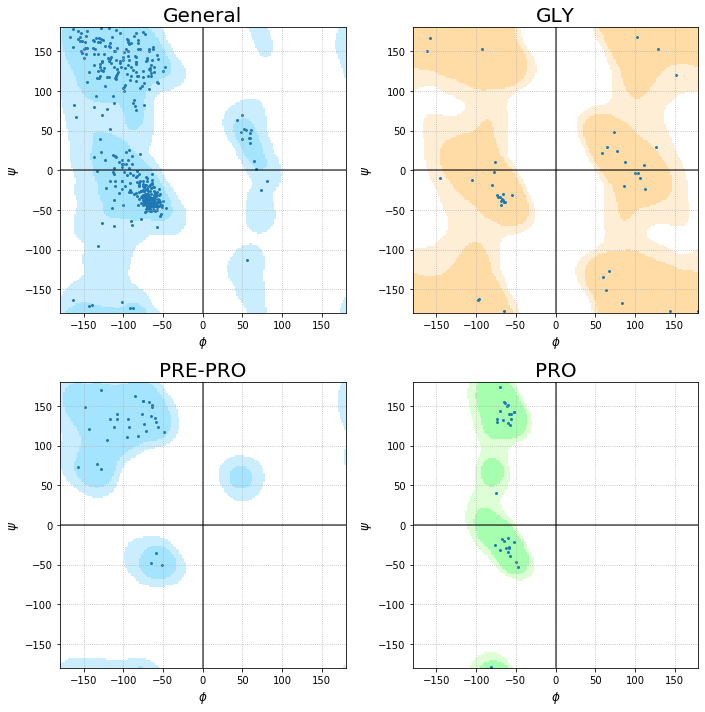

In [3]:
plot_ramachandran(pdb_file)

In [4]:
import nglview as nv #Let's see the 3D structure of the protein

_ColormakerRegistry()

In [5]:
nv.show_structure_file(pdb_file)

NGLWidget()

I know that this is something simple and not very useful. But it could be the first idea to perform more deep analysis and figures. The pyRAMA code can be easily modified to convert the simple plot into an interactive one. Such modification can be useful to identify outlayer residues and then visualize them using nglview. 

Independently what you whant to do, I hope you find useful this minitool. At least to make cool Ramachandran plots of your protein structures.